In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sklearn.manifold
import sklearn.cluster
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from PIL import Image, ImageEnhance 
files_val = glob.glob('./Dataset/*/*.JPG')
datos=len(files_val)
siz=30
Data=np.zeros((datos,siz*siz))
target=np.zeros(datos)
count=0
images=[]
#Función para calcular el brillo
def calculate_brightness(image):
    greyscale_image = image.convert('L')
    histogram = greyscale_image.histogram()
    pixels = sum(histogram)
    brightness = scale = len(histogram)

    for index in range(0, scale):
        ratio = histogram[index] / pixels
        brightness += ratio * (-scale + index)

    return 1 if brightness == 255 else brightness / scale
#Leo los datos por carpetas y asigno el target correspondiente
for i in range(10):
    files_val = glob.glob('./Dataset/'+str(i)+'/*.JPG')
    for names in files_val:
        im=Image.open(names)
        out=(im.convert('L')).resize((siz,siz))
        #Aqui voy a incluir una parte para tratar de normalizar el brillo
        enhancer = ImageEnhance.Brightness(out)
        images.append(enhancer.enhance(0.9/calculate_brightness(out)))
        Data[count,:]=(np.array(out).reshape((-1,1)).T).astype(float)
        target[count]=i
        count=count+1

In [2]:
#Divido el dataset y lo escalo
x_train,x_test,y_train,y_test,i_train,i_test= train_test_split(Data,target,images,train_size=0.7)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

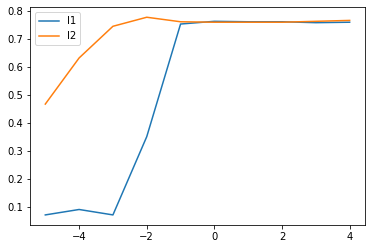

In [3]:
#Comparamos el comportamiento para varios valores de C y penalty
scores=np.zeros(10)
scores2=np.zeros(10)
for c in range(-5,5):
    C=10**c
    clf = LogisticRegression( C=C, penalty='l1', solver='saga', tol=0.01)
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    scores[c+5]=score
    clf = LogisticRegression( C=C, penalty='l2', solver='saga', tol=0.01)
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    scores2[c+5]=score
plt.plot(range(-5,5),scores)
plt.plot(range(-5,5),scores2)
plt.legend(['l1','l2'])

Text(0.5, 1.0, 'Matriz de Confusion (Score=0.77)')

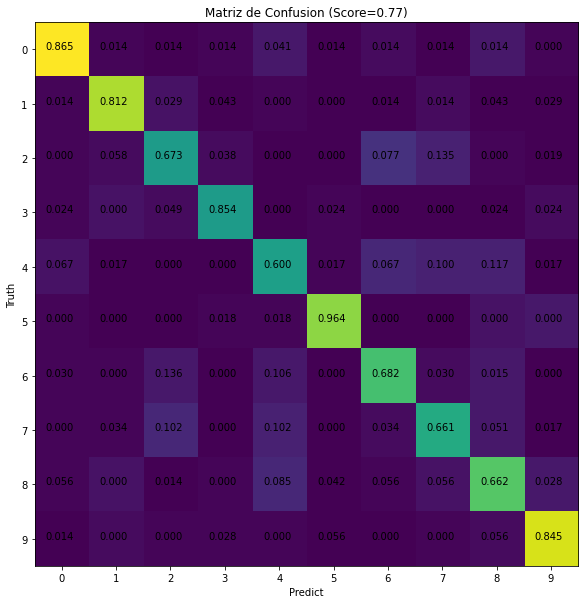

In [4]:
#Vemos que se comporta similarmente para l1 y l2 con C>1
#Ahora tomamos un valor y calculamos la matriz de confusion
clf = LogisticRegression( C=10**1, penalty='l2', solver='saga', tol=0.01)
MatConf=np.zeros((10,10))
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
for i in range(10):
    for i2 in range(10):
        MatConf[i,i2]=np.sum((y_test==i)*(y_pred==i2))
plt.figure(figsize=(10,10))
CNames=["0","1","2","3","4","5","6","7","8","9"]
Ejes=["Truth","Predict"]
plt.imshow(MatConf)
plt.ylabel("Truth")
plt.xlabel("Predict")
plt.xticks(np.arange(10),CNames)
plt.yticks(np.arange(10),CNames)
for i in range(10):
    for i2 in range(10):
        plt.text (i-0.3,i2,"%2.3f"%(MatConf[i,i2]/np.sum(MatConf[:,i2])))
plt.title("Matriz de Confusion (Score=%4.2f)"%score)

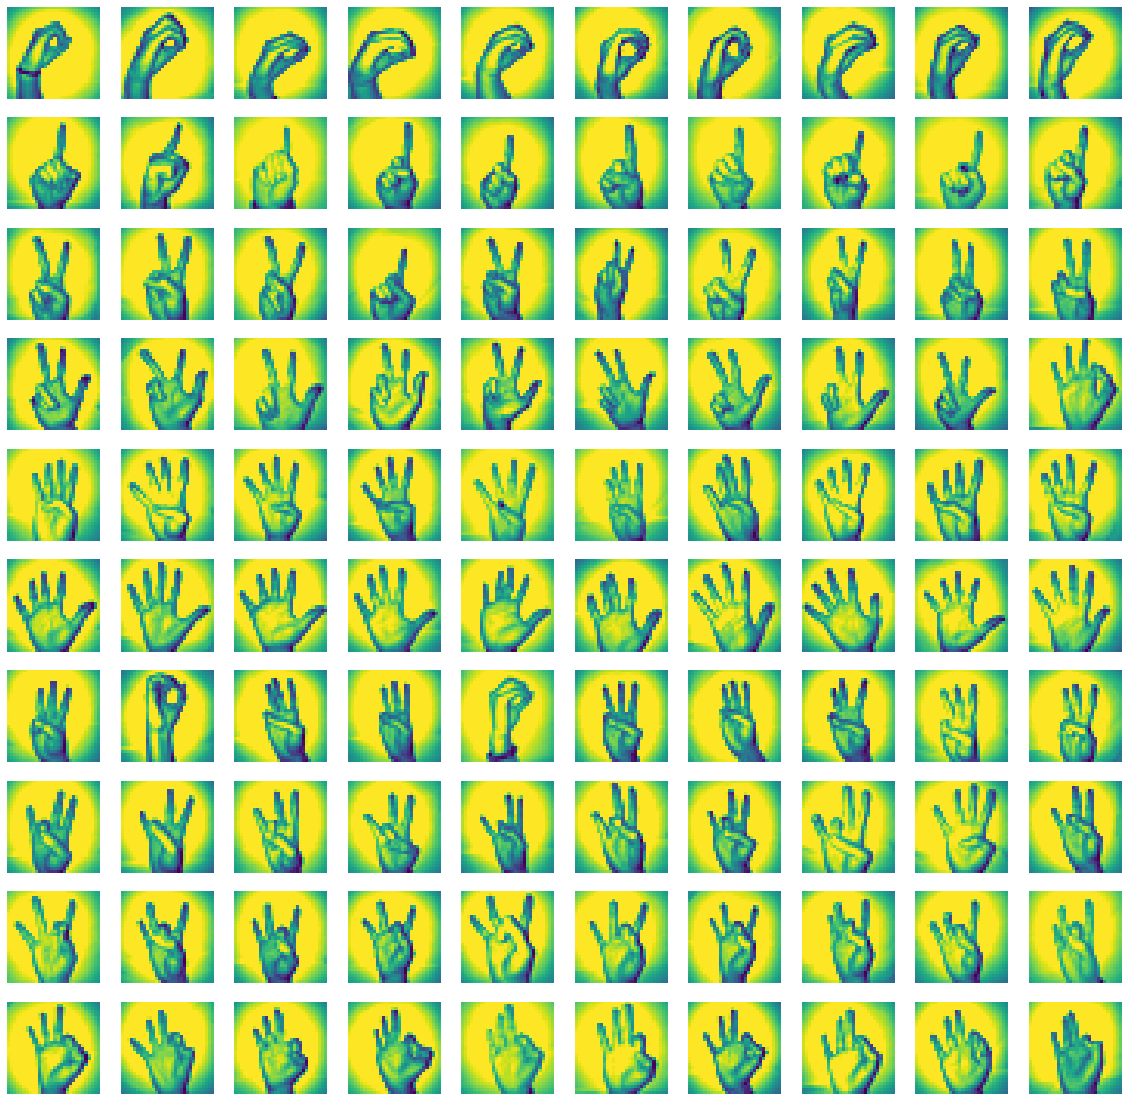

In [5]:
#Para visualizar lo que esta haciendo el código usamos la decision_function que cuantifica que tan probable es que una imagen
#se encuentre en determinado grupo y gráficamos las mas probables de cada grupo
confi=clf.decision_function(x_test)
plt.figure(figsize=(20,20))
for i in range(10):
    confii=confi[clf.predict(x_test)==i]
    confii=confii[:,i]
    listai=np.where(clf.predict(x_test)==i)[0]
    listai=listai[np.argsort(-confii)]
    for i2 in range(10):
        plt.subplot(10,10,i*10 +i2 +1)
        plt.imshow(i_test[listai[i2]])
        plt.axis('off')